## Importing the required libraries

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
from keras import regularizers

In [3]:
import os

In [4]:
mylist= os.listdir('C:\\Users\\anupa\\Desktop\\Speech Emotion\\Speech-Emotion-Analyzer\\Audio_Speech_Actors_01-24\\Rawdata\\')

In [5]:
type(mylist)
# mylist

list

In [6]:
print(mylist[10])

03-01-01-01-01-01-12.wav


In [7]:
print(mylist[10][6:-16])

01


## Plotting the audio file's waveform and its spectrogram

In [8]:
data, sampling_rate = librosa.load('C:\\Users\\anupa\\Desktop\\Speech Emotion\\Speech-Emotion-Analyzer\\Audio_Speech_Actors_01-24\\Rawdata\\03-01-05-02-02-01-01.wav')

Populating the interactive namespace from numpy and matplotlib


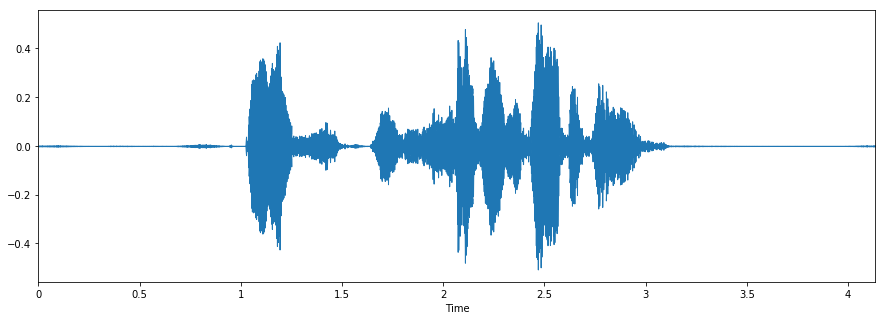

In [9]:
% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

D:\ProgramData\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


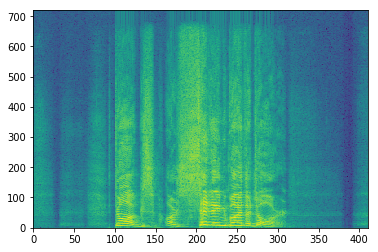

In [10]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('C:\\Users\\anupa\\Desktop\\Speech Emotion\\Speech-Emotion-Analyzer\\Audio_Speech_Actors_01-24\\Rawdata\\03-01-05-02-02-01-01.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')


plt.show()

## Setting the labels

In [11]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    elif item[:1]=='a':
        feeling_list.append('male_angry')
    elif item[:1]=='f':
        feeling_list.append('male_fearful')
    elif item[:1]=='h':
        feeling_list.append('male_happy')
    #elif item[:1]=='n':
        #feeling_list.append('neutral')
    elif item[:2]=='sa':
        feeling_list.append('male_sad')
#     else:
#         feeling_list.append('misc')

In [12]:
labels = pd.DataFrame(feeling_list)

In [13]:
labels[:500]

,0
0,male_calm
1,female_calm
2,male_calm
3,female_calm
4,male_calm
5,female_calm
6,male_calm
7,female_calm
8,male_calm
9,female_calm


## Getting the features of audio files using librosa

In [14]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('C:\\Users\\anupa\\Desktop\\Speech Emotion\\Speech-Emotion-Analyzer\\Audio_Speech_Actors_01-24\\Rawdata\\'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [66]:



#####deleeeeeteee

#if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
      
mylist[0]

'03-01-01-01-01-01-01.wav'

In [15]:
df[:5]

,feature
0,"[-70.2677641610773, -70.2677641610773, -70.267..."
1,"[-65.70765240065282, -65.70765240065282, -63.1..."
2,"[-65.4824988827423, -65.4824988827423, -65.482..."
3,"[-64.52844910346735, -64.52844910346735, -64.5..."
4,"[-62.36431052745468, -59.93472513811134, -61.8..."


In [16]:
df3 = pd.DataFrame(df['feature'].values.tolist())

df3[:5]

In [17]:
newdf = pd.concat([df3,labels], axis=1)

In [18]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [19]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,-70.267764,...,-57.447461,-58.896493,-58.751002,-57.405669,-60.078475,-63.426811,-62.638537,-61.082741,-60.234652,male_calm
1,-65.707652,-65.707652,-63.114722,-61.518999,-61.097138,-63.424602,-63.720067,-56.854608,-55.168972,-54.640002,...,-39.792147,-40.613166,-41.209201,-41.439204,-43.994282,-49.399616,-50.591601,-49.144064,-48.705645,female_calm
2,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,-65.482499,...,-31.346553,-34.310774,-35.800705,-35.936112,-37.631846,-40.119408,-41.662903,-41.323644,-40.710780,male_calm
3,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-65.928222,...,-48.674306,-48.596082,-47.602751,-43.049195,-42.659546,-43.188561,-44.001237,-43.610100,-44.698259,female_calm
4,-62.364311,-59.934725,-61.869600,-67.495764,-71.071811,-65.679826,-63.394396,-65.503349,-61.856639,-60.005421,...,-39.071328,-41.897121,-40.865430,-38.290605,-36.372397,-37.915779,-40.026125,-43.383777,-43.965398,male_calm


In [20]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
435,-47.491895,-47.491895,-47.491895,-47.491895,-47.491895,-47.491895,-47.549407,-47.491895,-47.047993,-46.753005,...,-46.767948,-46.347490,-46.382366,-45.685732,-45.235726,-46.160909,-47.270517,-47.097142,-46.934817,male_fearful
181,-56.465705,-55.121695,-55.758101,-57.083503,-58.640766,-60.950700,-61.008272,-61.238060,-63.767404,-62.940617,...,-53.956008,-56.767447,-56.896353,-57.070255,-57.417833,-55.939853,-55.611460,-55.141889,-54.155428,female_sad
26,-63.509118,-63.633813,-63.504395,-63.299428,-63.838960,-65.177300,-66.479497,-65.160203,-65.833741,-64.724393,...,-40.389947,-36.990450,-38.102470,-40.782663,-40.174314,-40.962998,-43.929966,-43.562015,-41.383231,male_calm
4,-62.364311,-59.934725,-61.869600,-67.495764,-71.071811,-65.679826,-63.394396,-65.503349,-61.856639,-60.005421,...,-39.071328,-41.897121,-40.865430,-38.290605,-36.372397,-37.915779,-40.026125,-43.383777,-43.965398,male_calm
293,-50.773067,-51.290537,-49.537144,-49.165073,-49.960850,-49.895120,-50.056533,-47.998513,-49.212078,-51.043201,...,-51.971631,-51.041481,-49.913501,-51.230732,-52.506655,-50.665369,-49.479515,-50.153623,-50.676300,female_angry
411,-42.857392,-40.275680,-40.181031,-40.028477,-41.299370,-40.615974,-38.716585,-37.227968,-36.882041,-37.313021,...,-47.782886,-48.033005,-48.330319,-48.191405,-49.559215,-49.631744,-49.046684,-48.784786,-48.677354,male_fearful
189,-66.215360,-66.215360,-66.215360,-66.215360,-66.215360,-65.488516,-61.722884,-59.527387,-57.858035,-57.953753,...,-43.166317,-42.332133,-42.192507,-44.320551,-44.484595,-43.416369,-42.507036,-42.704035,-40.249331,male_sad
238,-45.182998,-47.211669,-50.592894,-53.360218,-51.247242,-50.312643,-51.028291,-51.513125,-50.413727,-48.315339,...,-49.372282,-47.701173,-50.583976,-51.380535,-51.403674,-51.627796,-48.571527,-48.987322,-47.773933,female_sad
217,-70.089630,-66.397510,-67.012593,-64.960881,-58.976041,-58.283048,-62.317764,-57.455211,-54.140195,-52.624760,...,-54.938432,-57.793849,-60.318497,-60.131089,-58.903136,-59.495728,-63.499044,-64.405164,-63.669963,male_sad
3,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-64.528449,-65.928222,...,-48.674306,-48.596082,-47.602751,-43.049195,-42.659546,-43.188561,-44.001237,-43.610100,-44.698259,female_calm


In [21]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [22]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [23]:
train[10:20]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
328,-42.046777,-42.046461,-42.031773,-41.983722,-40.746086,-39.610490,-40.464287,-40.787814,-40.395497,-40.616361,...,-30.755086,-33.260313,-33.996253,-26.799293,-25.300767,-27.359387,-29.918242,-10.448124,-2.233963,female_angry
46,-46.148892,-45.965900,-46.465774,-50.426823,-50.016897,-49.716412,-49.669726,-49.205231,-50.857016,-52.708616,...,-24.640589,-25.523332,-25.462610,-25.559839,-25.279617,-25.475659,-26.474084,-24.673720,-23.300059,male_calm
108,-51.793581,-51.698678,-50.071744,-48.232907,-47.278102,-48.962610,-49.013752,-48.883962,-49.184266,-50.134320,...,-49.144631,-48.511766,-47.719249,-46.380838,-46.911242,-46.991629,-47.396616,-49.903906,-51.323641,female_happy
190,-58.865870,-58.865870,-58.865870,-58.865870,-58.865870,-58.865870,-58.865870,-58.865870,-58.778375,-59.406819,...,-56.021993,-55.395343,-55.132366,-55.372397,-55.525117,-56.382680,-58.850606,-58.568337,-56.615607,female_sad
284,-45.926538,-47.099597,-49.111809,-49.751451,-50.000951,-48.261825,-47.427477,-47.751723,-47.489718,-48.226338,...,-25.255584,-23.120896,-21.898277,-22.797743,-23.565636,-24.299835,-26.913490,-28.400662,-28.083453,female_angry
406,-46.710617,-46.710617,-46.710617,-46.710617,-46.710617,-46.710617,-46.710617,-46.710617,-46.710617,-46.710617,...,-33.761028,-33.411938,-33.547466,-32.139059,-33.785580,-33.675884,-33.164192,-31.373389,-31.620325,female_fearful
51,-55.193142,-55.723884,-56.979527,-60.773302,-55.671585,-53.729587,-53.668486,-53.156350,-54.001936,-55.969090,...,-52.854714,-49.178707,-49.217065,-50.817701,-50.598227,-50.945154,-50.485628,-51.919373,-52.982166,female_calm
87,-52.739674,-57.677276,-66.462502,-65.403128,-65.582105,-67.750203,-68.439627,-68.439627,-68.439627,-68.439627,...,-41.308884,-44.197681,-44.898780,-43.826728,-45.431425,-46.833351,-47.574795,-48.908173,-50.229206,female_calm
336,-41.509461,-41.211575,-41.279704,-41.039260,-41.261332,-41.949941,-41.279236,-40.551988,-40.417156,-40.504051,...,-32.731705,-32.707707,-31.940661,-32.185532,-33.970321,-34.747504,-34.679142,-34.679380,-36.013277,male_angry
177,-66.503901,-66.503901,-66.503901,-66.503901,-66.503901,-66.503901,-66.503901,-66.503901,-66.503901,-66.503901,...,-52.229426,-54.141428,-56.338935,-55.589702,-54.620144,-54.073232,-52.911318,-54.112369,-56.278374,female_sad


In [24]:
trainfeatures = train.iloc[:, :-1]

In [25]:
trainlabel = train.iloc[:, -1:]

In [26]:
testfeatures = test.iloc[:, :-1]

In [27]:
testlabel = test.iloc[:, -1:]

In [28]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [29]:
y_test

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 

In [30]:
X_train.shape

(346, 216)

## Changing dimension for CNN model

In [31]:

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [32]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(10))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 216, 256)          1536      
_________________________________________________________________
activation_1 (Activation)    (None, 216, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 216, 128)          163968    
_________________________________________________________________
activation_2 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 27, 128)           82048     
__________

In [34]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

### Removed the whole training part for avoiding unnecessary long epochs list

In [35]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700, validation_data=(x_testcnn, y_test))

Train on 346 samples, validate on 94 samples
Epoch 1/700
346/346 [==============================] - 23s 65ms/step - loss: 2.4600 - acc: 0.1185 - val_loss: 2.3959 - val_acc: 0.1170
Epoch 2/700
346/346 [==============================] - 0s 539us/step - loss: 2.3005 - acc: 0.1503 - val_loss: 2.3070 - val_acc: 0.1596
Epoch 3/700
346/346 [==============================] - 0s 527us/step - loss: 2.2650 - acc: 0.1416 - val_loss: 2.3039 - val_acc: 0.1489
Epoch 4/700
346/346 [==============================] - 0s 525us/step - loss: 2.2528 - acc: 0.1705 - val_loss: 2.3198 - val_acc: 0.0957
Epoch 5/700
346/346 [==============================] - 0s 525us/step - loss: 2.2364 - acc: 0.1676 - val_loss: 2.3309 - val_acc: 0.1170
Epoch 6/700
346/346 [==============================] - 0s 525us/step - loss: 2.2250 - acc: 0.1618 - val_loss: 2.2980 - val_acc: 0.1064
Epoch 7/700
346/346 [==============================] - 0s 527us/step - loss: 2.2107 - acc: 0.1994 - val_loss: 2.3222 - val_acc: 0.1064
Epoch 8/70

Epoch 61/700
346/346 [==============================] - 0s 527us/step - loss: 1.6936 - acc: 0.4277 - val_loss: 1.9512 - val_acc: 0.3511
Epoch 62/700
346/346 [==============================] - 0s 528us/step - loss: 1.6857 - acc: 0.4075 - val_loss: 1.9751 - val_acc: 0.3298
Epoch 63/700
346/346 [==============================] - 0s 525us/step - loss: 1.6889 - acc: 0.4335 - val_loss: 1.9914 - val_acc: 0.2872
Epoch 64/700
346/346 [==============================] - 0s 527us/step - loss: 1.6830 - acc: 0.4277 - val_loss: 1.9784 - val_acc: 0.2553
Epoch 65/700
346/346 [==============================] - 0s 542us/step - loss: 1.6741 - acc: 0.4277 - val_loss: 1.9524 - val_acc: 0.3085
Epoch 66/700
346/346 [==============================] - 0s 542us/step - loss: 1.6763 - acc: 0.4133 - val_loss: 1.9494 - val_acc: 0.3085
Epoch 67/700
346/346 [==============================] - 0s 539us/step - loss: 1.6570 - acc: 0.4249 - val_loss: 1.9580 - val_acc: 0.3085
Epoch 68/700
346/346 [==========================

346/346 [==============================] - 0s 525us/step - loss: 1.4249 - acc: 0.5173 - val_loss: 1.8249 - val_acc: 0.3617
Epoch 122/700
346/346 [==============================] - 0s 519us/step - loss: 1.4133 - acc: 0.5145 - val_loss: 1.8777 - val_acc: 0.3723
Epoch 123/700
346/346 [==============================] - 0s 527us/step - loss: 1.4124 - acc: 0.5405 - val_loss: 1.8566 - val_acc: 0.3830
Epoch 124/700
346/346 [==============================] - 0s 522us/step - loss: 1.4089 - acc: 0.5260 - val_loss: 1.8567 - val_acc: 0.3404
Epoch 125/700
346/346 [==============================] - 0s 536us/step - loss: 1.3929 - acc: 0.5202 - val_loss: 1.8751 - val_acc: 0.3511
Epoch 126/700
346/346 [==============================] - 0s 530us/step - loss: 1.4018 - acc: 0.5116 - val_loss: 1.8403 - val_acc: 0.3511
Epoch 127/700
346/346 [==============================] - 0s 528us/step - loss: 1.3882 - acc: 0.5202 - val_loss: 1.8235 - val_acc: 0.3617
Epoch 128/700
346/346 [==============================] 

Epoch 181/700
346/346 [==============================] - 0s 525us/step - loss: 1.2079 - acc: 0.5636 - val_loss: 1.7900 - val_acc: 0.3085
Epoch 182/700
346/346 [==============================] - 0s 531us/step - loss: 1.2131 - acc: 0.5665 - val_loss: 1.8441 - val_acc: 0.3936
Epoch 183/700
346/346 [==============================] - 0s 562us/step - loss: 1.2220 - acc: 0.5636 - val_loss: 1.8349 - val_acc: 0.3617
Epoch 184/700
346/346 [==============================] - 0s 545us/step - loss: 1.2093 - acc: 0.6012 - val_loss: 1.7588 - val_acc: 0.3511
Epoch 185/700
346/346 [==============================] - 0s 525us/step - loss: 1.2103 - acc: 0.5751 - val_loss: 1.8114 - val_acc: 0.4255
Epoch 186/700
346/346 [==============================] - 0s 533us/step - loss: 1.2096 - acc: 0.5665 - val_loss: 1.7479 - val_acc: 0.3723
Epoch 187/700
346/346 [==============================] - 0s 539us/step - loss: 1.1966 - acc: 0.5780 - val_loss: 1.8005 - val_acc: 0.3723
Epoch 188/700
346/346 [==================

Epoch 241/700
346/346 [==============================] - 0s 533us/step - loss: 1.0708 - acc: 0.6358 - val_loss: 1.7299 - val_acc: 0.4043
Epoch 242/700
346/346 [==============================] - 0s 530us/step - loss: 1.0492 - acc: 0.6387 - val_loss: 1.7217 - val_acc: 0.4149
Epoch 243/700
346/346 [==============================] - 0s 525us/step - loss: 1.0580 - acc: 0.6503 - val_loss: 1.7676 - val_acc: 0.3830
Epoch 244/700
346/346 [==============================] - 0s 525us/step - loss: 1.0360 - acc: 0.6590 - val_loss: 1.7646 - val_acc: 0.4043
Epoch 245/700
346/346 [==============================] - 0s 528us/step - loss: 1.0633 - acc: 0.6416 - val_loss: 1.7139 - val_acc: 0.3936
Epoch 246/700
346/346 [==============================] - 0s 530us/step - loss: 1.0453 - acc: 0.6387 - val_loss: 1.7465 - val_acc: 0.3723
Epoch 247/700
346/346 [==============================] - 0s 533us/step - loss: 1.0443 - acc: 0.6272 - val_loss: 1.7179 - val_acc: 0.4043
Epoch 248/700
346/346 [==================

Epoch 301/700
346/346 [==============================] - 0s 542us/step - loss: 0.9264 - acc: 0.6936 - val_loss: 1.7080 - val_acc: 0.4043
Epoch 302/700
346/346 [==============================] - 0s 539us/step - loss: 0.9295 - acc: 0.6994 - val_loss: 1.6859 - val_acc: 0.3936
Epoch 303/700
346/346 [==============================] - 0s 539us/step - loss: 0.9083 - acc: 0.7052 - val_loss: 1.6734 - val_acc: 0.4043
Epoch 304/700
346/346 [==============================] - 0s 536us/step - loss: 0.9111 - acc: 0.6879 - val_loss: 1.7496 - val_acc: 0.3723
Epoch 305/700
346/346 [==============================] - 0s 535us/step - loss: 0.9163 - acc: 0.6908 - val_loss: 1.6644 - val_acc: 0.3723
Epoch 306/700
346/346 [==============================] - 0s 538us/step - loss: 0.9092 - acc: 0.7023 - val_loss: 1.7171 - val_acc: 0.3511
Epoch 307/700
346/346 [==============================] - 0s 533us/step - loss: 0.9046 - acc: 0.6850 - val_loss: 1.7754 - val_acc: 0.3936
Epoch 308/700
346/346 [==================

Epoch 361/700
346/346 [==============================] - 0s 532us/step - loss: 0.8073 - acc: 0.7457 - val_loss: 1.7171 - val_acc: 0.4043
Epoch 362/700
346/346 [==============================] - 0s 536us/step - loss: 0.8076 - acc: 0.7341 - val_loss: 1.6594 - val_acc: 0.3936
Epoch 363/700
346/346 [==============================] - 0s 533us/step - loss: 0.8011 - acc: 0.7428 - val_loss: 1.7182 - val_acc: 0.4362
Epoch 364/700
346/346 [==============================] - 0s 536us/step - loss: 0.8025 - acc: 0.7514 - val_loss: 1.6880 - val_acc: 0.4255
Epoch 365/700
346/346 [==============================] - 0s 545us/step - loss: 0.7886 - acc: 0.7486 - val_loss: 1.6523 - val_acc: 0.3936
Epoch 366/700
346/346 [==============================] - 0s 533us/step - loss: 0.8006 - acc: 0.7514 - val_loss: 1.6400 - val_acc: 0.3723
Epoch 367/700
346/346 [==============================] - 0s 539us/step - loss: 0.7921 - acc: 0.7457 - val_loss: 1.6610 - val_acc: 0.4043
Epoch 368/700
346/346 [==================

Epoch 421/700
346/346 [==============================] - 0s 548us/step - loss: 0.6823 - acc: 0.8092 - val_loss: 1.7019 - val_acc: 0.3936
Epoch 422/700
346/346 [==============================] - 0s 525us/step - loss: 0.6908 - acc: 0.7832 - val_loss: 1.6867 - val_acc: 0.3936
Epoch 423/700
346/346 [==============================] - 0s 525us/step - loss: 0.6873 - acc: 0.7803 - val_loss: 1.7137 - val_acc: 0.4255
Epoch 424/700
346/346 [==============================] - 0s 527us/step - loss: 0.6738 - acc: 0.8035 - val_loss: 1.6994 - val_acc: 0.3830
Epoch 425/700
346/346 [==============================] - 0s 527us/step - loss: 0.7086 - acc: 0.7775 - val_loss: 1.6723 - val_acc: 0.3936
Epoch 426/700
346/346 [==============================] - 0s 527us/step - loss: 0.6718 - acc: 0.8035 - val_loss: 1.6829 - val_acc: 0.3723
Epoch 427/700
346/346 [==============================] - 0s 532us/step - loss: 0.6632 - acc: 0.8006 - val_loss: 1.7086 - val_acc: 0.4149
Epoch 428/700
346/346 [==================

Epoch 481/700
346/346 [==============================] - 0s 525us/step - loss: 0.5804 - acc: 0.8439 - val_loss: 1.7651 - val_acc: 0.3830
Epoch 482/700
346/346 [==============================] - 0s 530us/step - loss: 0.5847 - acc: 0.8179 - val_loss: 1.7490 - val_acc: 0.4468
Epoch 483/700
346/346 [==============================] - 0s 614us/step - loss: 0.5924 - acc: 0.8324 - val_loss: 1.7397 - val_acc: 0.3936
Epoch 484/700
346/346 [==============================] - 0s 545us/step - loss: 0.5776 - acc: 0.8121 - val_loss: 1.7436 - val_acc: 0.4149
Epoch 485/700
346/346 [==============================] - 0s 525us/step - loss: 0.5733 - acc: 0.8324 - val_loss: 1.7285 - val_acc: 0.3511
Epoch 486/700
346/346 [==============================] - 0s 559us/step - loss: 0.5779 - acc: 0.8410 - val_loss: 1.7238 - val_acc: 0.4149
Epoch 487/700
346/346 [==============================] - 0s 579us/step - loss: 0.5700 - acc: 0.8295 - val_loss: 1.7447 - val_acc: 0.3830
Epoch 488/700
346/346 [==================

Epoch 541/700
346/346 [==============================] - 0s 528us/step - loss: 0.4870 - acc: 0.8642 - val_loss: 1.8151 - val_acc: 0.4149
Epoch 542/700
346/346 [==============================] - 0s 538us/step - loss: 0.4807 - acc: 0.8757 - val_loss: 1.7876 - val_acc: 0.3617
Epoch 543/700
346/346 [==============================] - 0s 527us/step - loss: 0.4778 - acc: 0.8815 - val_loss: 1.8269 - val_acc: 0.3936
Epoch 544/700
346/346 [==============================] - 0s 527us/step - loss: 0.4876 - acc: 0.8699 - val_loss: 1.7499 - val_acc: 0.3936
Epoch 545/700
346/346 [==============================] - 0s 539us/step - loss: 0.4696 - acc: 0.8757 - val_loss: 1.8680 - val_acc: 0.4149
Epoch 546/700
346/346 [==============================] - 0s 530us/step - loss: 0.4866 - acc: 0.8671 - val_loss: 1.8067 - val_acc: 0.4362
Epoch 547/700
346/346 [==============================] - 0s 530us/step - loss: 0.4698 - acc: 0.8786 - val_loss: 1.8242 - val_acc: 0.3617
Epoch 548/700
346/346 [==================

Epoch 601/700
346/346 [==============================] - 0s 605us/step - loss: 0.3864 - acc: 0.9162 - val_loss: 1.7979 - val_acc: 0.4149
Epoch 602/700
346/346 [==============================] - 0s 611us/step - loss: 0.3974 - acc: 0.9075 - val_loss: 1.8644 - val_acc: 0.4255
Epoch 603/700
346/346 [==============================] - 0s 602us/step - loss: 0.3838 - acc: 0.9046 - val_loss: 1.9194 - val_acc: 0.4149
Epoch 604/700
346/346 [==============================] - 0s 628us/step - loss: 0.3915 - acc: 0.8844 - val_loss: 1.8029 - val_acc: 0.4149
Epoch 605/700
346/346 [==============================] - 0s 533us/step - loss: 0.3870 - acc: 0.9104 - val_loss: 1.8047 - val_acc: 0.4255
Epoch 606/700
346/346 [==============================] - 0s 522us/step - loss: 0.3809 - acc: 0.9191 - val_loss: 1.8617 - val_acc: 0.4149
Epoch 607/700
346/346 [==============================] - 0s 531us/step - loss: 0.3941 - acc: 0.9017 - val_loss: 1.8532 - val_acc: 0.3830
Epoch 608/700
346/346 [==================

Epoch 661/700
346/346 [==============================] - 0s 548us/step - loss: 0.3091 - acc: 0.9422 - val_loss: 1.8644 - val_acc: 0.4362
Epoch 662/700
346/346 [==============================] - 0s 530us/step - loss: 0.3055 - acc: 0.9509 - val_loss: 2.0034 - val_acc: 0.3936
Epoch 663/700
346/346 [==============================] - 0s 553us/step - loss: 0.3042 - acc: 0.9480 - val_loss: 1.9071 - val_acc: 0.4362
Epoch 664/700
346/346 [==============================] - 0s 579us/step - loss: 0.3120 - acc: 0.9451 - val_loss: 1.9689 - val_acc: 0.4255
Epoch 665/700
346/346 [==============================] - 0s 536us/step - loss: 0.2986 - acc: 0.9595 - val_loss: 1.9838 - val_acc: 0.4043
Epoch 666/700
346/346 [==============================] - 0s 539us/step - loss: 0.2978 - acc: 0.9393 - val_loss: 1.8395 - val_acc: 0.4681
Epoch 667/700
346/346 [==============================] - 0s 585us/step - loss: 0.2977 - acc: 0.9451 - val_loss: 1.9661 - val_acc: 0.4149
Epoch 668/700
346/346 [==================

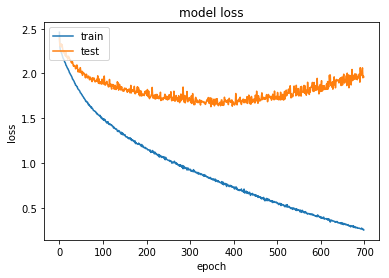

In [36]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [37]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\anupa\Desktop\Speech Emotion\Speech-Emotion-Analyzer\saved_models\Emotion_Voice_Detection_Model.h5 


In [38]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [39]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
acc: 43.62%


## Predicting emotions on the test data

In [40]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

94/94 [==============================] - 0s 609us/step


In [41]:
preds

array([[3.41047253e-03, 8.65637418e-03, 1.24423094e-01, 8.17422509e-01,
        4.19002920e-02, 1.03064501e-09, 2.82242927e-05, 1.14947572e-04,
        2.35321917e-04, 3.80882132e-03],
       [4.71188723e-05, 2.47470900e-01, 6.25458022e-04, 2.10905564e-03,
        7.49720216e-01, 1.47255751e-16, 2.70591194e-09, 2.06146888e-05,
        4.06108256e-07, 6.16783745e-06],
       [3.24727237e-01, 7.53381383e-03, 7.70879984e-02, 1.84623767e-02,
        3.42318080e-02, 1.51945378e-05, 2.89828493e-03, 4.24663872e-01,
        2.51034945e-02, 8.52760077e-02],
       [1.77976253e-04, 9.70940351e-01, 2.97029084e-03, 2.65236944e-04,
        2.55908482e-02, 1.04265189e-13, 7.72312347e-08, 1.52677364e-06,
        5.95235406e-06, 4.77535104e-05],
       [1.28897373e-02, 6.97054490e-02, 2.84032128e-03, 1.75902203e-01,
        3.70830204e-03, 3.76268181e-05, 5.25497133e-03, 1.01805553e-01,
        3.78818810e-01, 2.49037012e-01],
       [7.45176226e-02, 9.01412219e-04, 5.70394518e-03, 2.62528629e-04,
   

In [42]:
preds1=preds.argmax(axis=1)

In [43]:
preds1

array([3, 4, 7, 1, 8, 9, 0, 2, 3, 1, 0, 1, 1, 1, 3, 1, 3, 4, 2, 3, 1, 1,
       0, 7, 1, 2, 0, 2, 9, 1, 2, 8, 2, 7, 1, 0, 7, 3, 8, 1, 7, 1, 8, 7,
       6, 3, 8, 1, 3, 6, 2, 3, 6, 0, 4, 8, 9, 2, 3, 3, 3, 7, 4, 1, 7, 2,
       5, 7, 4, 0, 2, 2, 6, 3, 0, 4, 1, 7, 7, 1, 7, 6, 5, 0, 1, 0, 4, 1,
       4, 2, 5, 5, 4, 7], dtype=int64)

In [44]:
abc = preds1.astype(int).flatten()

In [45]:
predictions = (lb.inverse_transform((abc)))

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [46]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,female_happy
1,female_sad
2,male_fearful
3,female_calm
4,male_happy
5,male_sad
6,female_angry
7,female_fearful
8,female_happy
9,female_calm


In [47]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [48]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_fearful
1,female_sad
2,female_angry
3,female_calm
4,male_fearful
5,female_fearful
6,female_angry
7,female_fearful
8,female_happy
9,female_calm


In [49]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [50]:
finaldf[170:180]

,actualvalues,predictedvalues


In [51]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
female_angry,11
female_calm,14
female_fearful,10
female_happy,12
female_sad,7
male_angry,4
male_calm,4
male_fearful,13
male_happy,7


In [52]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,10
female_calm,19
female_fearful,12
female_happy,13
female_sad,9
male_angry,4
male_calm,5
male_fearful,13
male_happy,6


In [53]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

#### The file 'output10.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

In [54]:
data, sampling_rate = librosa.load('output10.wav')

Populating the interactive namespace from numpy and matplotlib


D:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shuffle', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


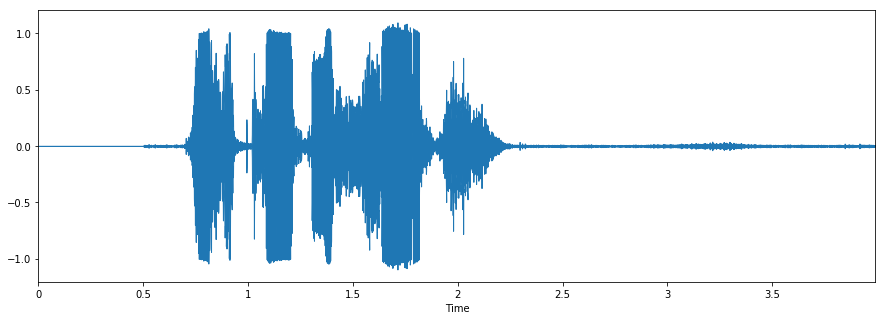

In [55]:
% pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [56]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('output10.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [57]:
livedf2= pd.DataFrame(data=livedf2)

In [58]:
livedf2 = livedf2.stack().to_frame().T

In [59]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-18.203564,-21.471836,-22.52221,-21.712259,-22.264288,-20.707904,-21.726444,-21.76865,-24.302736,-22.250634,...,-24.273819,-24.639939,-24.929152,-24.43919,-25.210171,-24.740646,-22.311913,-22.579805,-22.31466,-21.552436


In [60]:
twodim= np.expand_dims(livedf2, axis=2)

In [61]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 75ms/step


In [62]:
livepreds

array([[7.1901661e-01, 2.1573160e-06, 1.3875455e-03, 9.9444855e-04,
        6.4013351e-04, 4.3799475e-02, 2.7522244e-02, 7.8171790e-03,
        5.0714366e-02, 1.4810589e-01]], dtype=float32)

In [63]:
livepreds1=livepreds.argmax(axis=1)

In [64]:
liveabc = livepreds1.astype(int).flatten()

In [65]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['female_angry'], dtype=object)